### Importing Necessary Modules

`pandas` and `numpy` for dataframe processing.

`sklearn` as a source of regressor models

`pulp` linear problem solvers for team composition

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpInteger, LpStatus, LpBinary, LpConstraintVar, LpConstraint, LpAffineExpression
import matplotlib.pyplot as plt

### Importing the Data

FPL has API which can be used to query current and historical data. Luckily, its also being aggregated into a single CSV at https://github.com/vaastav/Fantasy-Premier-League (imported as git submodule)

In [2]:
df = pd.read_csv("data/data/cleaned_merged_seasons.csv")

/tmp/ipykernel_2743378/3321494464.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data/cleaned_merged_seasons.csv")


In [3]:
# Remove string data from the dataset
del df["season_x"]
del df["opp_team_name"]
del df["round"]

In [4]:
# Create Unique Player IDs
df['player_id'] = df['name'].astype('category').cat.codes

# Convert Kickoff Time to datetime and Extract Features
df['kickoff_time'] = pd.to_datetime(df['kickoff_time'])
df['year'] = df['kickoff_time'].dt.year
df['month'] = df['kickoff_time'].dt.month
df['day_of_month'] = df['kickoff_time'].dt.day
df['day_of_week'] = df['kickoff_time'].dt.dayofweek
df['time'] = df['kickoff_time'].dt.hour * 100 + df['kickoff_time'].dt.minute

# Convert 'was_home' from boolean to int64
df['was_home'] = df['was_home'].astype(int)

# Convert positions to numbers
position_mapping = {'GK': 0, 'DEF': 1, 'MID': 2, 'FWD': 3}
df['position'] = df['position'].map(position_mapping)

In [5]:
# Create a dictionary mapping player_id to team_x
player_team_mapping = df[df['team_x'].notna()][['player_id', 'team_x']].set_index('player_id')['team_x'].to_dict()

# Fill in NaN values in 'team_x' based on player_id mapping
for index, row in df.iterrows():
    if pd.isnull(row['team_x']):
        player_id = row['player_id']
        if player_id in player_team_mapping:
            df.at[index, 'team_x'] = player_team_mapping[player_id]


In [6]:
# Create a dictionary to map teams to codes
team_codes = {}
teams = df['team_x'].dropna().unique()
teams.sort()  # Sort teams alphabetically

# Assign codes to teams
for i, team in enumerate(teams):
    team_codes[team] = i + 1  # Start codes from 1

# Create a new column 'team_code' in the DataFrame
df['team_code'] = df['team_x'].map(team_codes)

# Display team names and their codes
for team, code in team_codes.items():
    print(f"Team: {team}, Code: {code}")


Team: Arsenal, Code: 1
Team: Aston Villa, Code: 2
Team: Bournemouth, Code: 3
Team: Brentford, Code: 4
Team: Brighton, Code: 5
Team: Burnley, Code: 6
Team: Chelsea, Code: 7
Team: Crystal Palace, Code: 8
Team: Everton, Code: 9
Team: Fulham, Code: 10
Team: Leeds, Code: 11
Team: Leicester, Code: 12
Team: Liverpool, Code: 13
Team: Luton, Code: 14
Team: Man City, Code: 15
Team: Man Utd, Code: 16
Team: Newcastle, Code: 17
Team: Norwich, Code: 18
Team: Nott'm Forest, Code: 19
Team: Sheffield Utd, Code: 20
Team: Southampton, Code: 21
Team: Spurs, Code: 22
Team: Watford, Code: 23
Team: West Brom, Code: 24
Team: West Ham, Code: 25
Team: Wolves, Code: 26


In [7]:
# Create a new column 'new_value' and initialize it with the 'value' column
df['new_value'] = df['value']

# Create a dictionary to store the manually input 'new_value' for each player name
player_new_value_dict = {
    'Erling Haaland': 140,
    'Harry Kane': 125,
    'Mohamed Salah': 125,
    'Kevin De Bruyne': 105,
    'Marcus Rashford': 90,
    'Son Heung-min': 90,
    'Heung-Min Son': 90,
    'Bruno Miguel Borges Fernandes': 85,
    'Bukayo Saka': 85,
    'Martin Ødegaard': 85,
    'Trent Alexander-Arnold': 80,
    'Diogo Jota': 80,
    'Gabriel Martinelli': 80,
    'Ollie Watkins': 80,
    'Callum Wilson': 80,
    'Darwin Nuñez': 75,
    'Phil Foden': 75,
    'Jack Grealish': 75,
    'Kai Havertz': 75,
    'Luis Diaz': 75,
    'James Maddison': 75,
    'Aleksandar Mitrović': 75,
    'Jarrod Bowen': 70,
    'Dejan Kulusevski': 70,
    'Mason Mount': 70,
    'Richarlison': 70,
    'Jadon Sancho': 70,
    'Raheem Sterling': 70,
    'Leandro Trossard': 70,
    'Miguel Almirón Rejala': 65,
    'Harvey Barnes': 65,
    'Bernardo Veiga de Carvalho e Silva': 65,
    'Moussa Diaby': 65,
    'Eberechi Eze': 65,
    'Pascal Gross': 65,
    'Julian Alvarez': 65,
    'Solly March': 65,
    'Kaoru Mitoma': 65,
    'Kieran Trippier': 65,
    'Joao Cancelo': 60,
    'Danny Ings': 60,
    'Lucas Paqueta': 60,
    'Alexis Mac Allister': 60,
    'Virgil Van Dijk': 60,
    'Yoane Wissa': 60,
    'Reece James': 55,
    'Benjamin Chilwell': 55,
    'Alisson Ramses Becker': 55,
    'Ederson Santana de Moraes': 55,
    'Nick Pope': 55,
    'Eddie Nketiah': 55,
    'Ruben Gato Alves Dias': 55,
    'John Stones': 55,
    'Luke Shaw': 55,
    'Aaron Ramsdale': 50,
    'Pervis Estupiñan': 50,
    'William Saliba': 50,
    'Fabian Schär': 50,
    'Gabriel dos Santos Magalhães': 50,
    'Robert Sanchez': 45,
    'Jordan Pickford': 45,
    'Sven Botman': 45,
    'Tyrone Mings': 45
}

# Update the 'new_value' column with the manually input 'new_value' for each player name
for player_name, new_value in player_new_value_dict.items():
    df.loc[df['name'] == player_name, 'new_value'] = new_value

# Define a dictionary to map player names to their new teams
player_team_changes = {
    'Mason Mount': 'Man Utd',
    'James Maddison': 'Spurs',
    'Declan Rice': 'Arsenal',
    'Kai Havertz': 'Arsenal',
    'Youri Tielemans': 'Aston Villa',
    'João Pedro Junqueira de Jesus': 'Brighton',
    'Robert Sánchez': 'Chelsea',
    'Ashley Young': 'Everton',
    'Alexis Mac Allister': 'Liverpool',
    'Harvey Barnes': 'Newcastle'
}

# Update the 'team_x' column for the players
for player_name, new_team in player_team_changes.items():
    df.loc[df['name'] == player_name, 'team_x'] = new_team

In [8]:
# Drop NaN values
df = df.dropna()

# Prepare Data
X = df.drop(['name', 'kickoff_time', 'team_x','total_points'], axis=1)
y = df['total_points']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Creating ML model and comparing several models

In [9]:
# Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions on the test set
lr_y_pred = lr_model.predict(X_test)

# Evaluate the model using MSE
lr_mse = mean_squared_error(y_test, lr_y_pred)
print("Linear Regression Mean Squared Error (MSE):", lr_mse)

Linear Regression Mean Squared Error (MSE): 0.28363738950896106


In [10]:
# Gradient Boosting model
gb_model = GradientBoostingRegressor()

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions on the test set
gb_y_pred = gb_model.predict(X_test)

# Evaluate the model using MSE
gb_mse = mean_squared_error(y_test, gb_y_pred)
print("Gradient Boosting Mean Squared Error (MSE):", gb_mse)

Gradient Boosting Mean Squared Error (MSE): 0.10373169720763079


In [11]:
# Histogram-based Gradient Boosting model
hgb_model = HistGradientBoostingRegressor()

# Train the model
hgb_model.fit(X_train, y_train)

# Make predictions on the test set
hgb_y_pred = hgb_model.predict(X_test)

# Evaluate the model using MSE
hgb_mse = mean_squared_error(y_test, hgb_y_pred)
print("Histogram-based Gradient Boosting Mean Squared Error (MSE):", gb_mse)

Histogram-based Gradient Boosting Mean Squared Error (MSE): 0.10373169720763079


In [12]:
# Random Forest Regression model
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_y_pred = rf_model.predict(X_test)

# Evaluate the model using MSE
rf_mse = mean_squared_error(y_test, rf_y_pred)
print("Random Forest Mean Squared Error (MSE):", rf_mse)

Random Forest Mean Squared Error (MSE): 0.03492234805387241


In [ ]:
# Random Forest Regression model - tweaked
rf_model = RandomForestRegressor(n_estimators=10000)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_y_pred = rf_model.predict(X_test)

# Evaluate the model using MSE
rf_mse = mean_squared_error(y_test, rf_y_pred)
print("Random Forest Mean Squared Error (MSE):", rf_mse)

### Calculating Weighted Predicted Points

Players are not getting any younger, the points they would have scored last year are no longer important.
This makes the model to biased toward recent matches

In [13]:
# Predict total_points for all players
df['predicted_total_points'] = rf_model.predict(X)

# Convert position to string
df['position'] = df['position'].astype(str)

# Convert kickoff_time to timezone-naive datetime
df['kickoff_time'] = pd.to_datetime(df['kickoff_time']).dt.tz_localize(None)

# Calculate days ago for each match
df['days_ago'] = (pd.Timestamp('now') - df['kickoff_time']).dt.days

# Define the decay rate for exponential weighting
decay_rate = 0.001

# Calculate weights based on match dates
df['weight'] = np.exp(-decay_rate * df['days_ago'])


### Match weight

Some matches are more complicated than the others, the model should be biased toward the matches with leaders of the league

In [14]:
# Fixture difficulty ratings dictionary
fixture_difficulty = {
    'Arsenal': [1.86, 1.08, 1.65, 1.42, 1.23],
    'Aston Villa': [0.84, 1.73, 1.25, 0.83, 1.57],
    'Bournemouth': [1.60, 0.83, 1.56, 0.99, 1.50],
    'Brentford': [1.56, 1.16, 1.57, 1.81, 0.84],
    'Brighton': [1.87, 1.34, 1.60, 1.30, 0.93],
    'Burnley': [0.97, 0, 1.42, 1.56, 1.36],
    'Chelsea': [1.29, 1.11, 1.87, 1.86, 1.31],
    'Crystal Palace': [1.40, 1.29, 0.99, 1.83, 0.95],
    'Everton': [1.65, 0.95, 1.83, 1.40, 1.29],
    'Fulham': [1.23, 1.47, 0.83, 0.58, 1.87],
    'Liverpool': [1.02, 1.81, 0.84, 1.42, 1.34],
    'Man City': [1.25, 1.30, 1.40, 1.65, 1.11],
    'Man Utd': [1.83, 1.06, 1.86, 0.83, 1.37],
    'Newcastle': [1.42, 0.58, 1.29, 0.89, 1.47],
    'Nott’m Forest': [0.83, 1.89, 0.93, 1.02, 1.75],
    'Sheffield Utd': [1.57, 1.36, 0.97, 1.73, 1.06],
    'Spurs': [0.99, 1.42, 1.31, 1.25, 1.89],
    'West Ham': [1.31, 1.50, 0.89, 1.39, 0.97],
    'Wolves': [0.93, 1.37, 1.23, 1.08, 1.29]
}

# Define fixture weights and match weights in the ratio of 24, 22, 20, 18, 16
fixture_weights = {
    'Arsenal': [1.4664], 'Aston Villa': [1.2328], 'Bournemouth': [1.2968], 'Brentford': [1.4038],
    'Brighton': [1.4464], 'Burnley': [1.0156], 'Chelsea': [1.4722], 'Crystal Palace': [1.2992],
    'Everton': [1.4294], 'Fulham': [1.1882], 'Liverpool': [1.281], 'Man City': [1.3406],
    'Man Utd': [1.413], 'Newcastle': [1.1218], 'Nott’m Forest': [1.2646], 'Sheffield Utd': [1.351],
    'Spurs': [1.3394], 'West Ham': [1.2278], 'Wolves': [1.1714]
}

# Create a new column 'weighted_predicted_points'
df['weighted_predicted_points'] = df.apply(
    lambda row: row['predicted_total_points'] * row['weight'] * fixture_weights.get(row['team_x'], [0])[0],
    axis=1
)

### Show most performing players

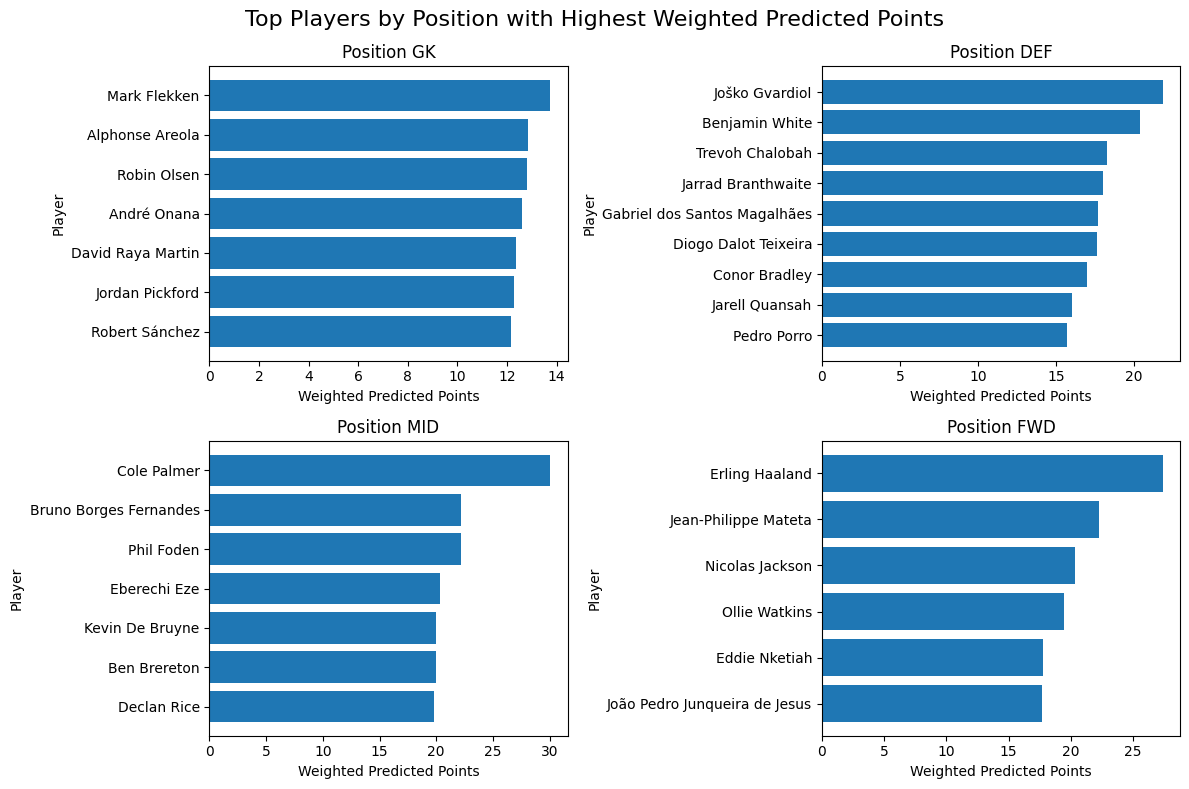

In [15]:
# Create a dictionary to map positions to their index
position_indices = {'0.0': 0, '1.0': 1, '2.0': 2, '3.0': 3}
position_labels = {'0.0': 'GK', '1.0': 'DEF', '2.0': 'MID', '3.0': 'FWD'}

# Initialize a figure with subplots for each position
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Top Players by Position with Highest Weighted Predicted Points', fontsize=16)

# Loop through each position and create a subplot
for position, ax in zip(position_indices.keys(), axes.flat):
    # Filter players by position
    position_players = df[df['position'] == position]
    
    # Sort players by 'weighted_predicted_points' in descending order
    position_players_sorted = position_players.sort_values(by='weighted_predicted_points', ascending=False)
    
    # Select the top 10 players
    top_position_players = position_players_sorted.head(10)
    
    # Create a bar plot for the position
    ax.barh(top_position_players['name'], top_position_players['weighted_predicted_points'])
    ax.set_title(f'Position {position_labels[position]}')
    ax.set_xlabel('Weighted Predicted Points')
    ax.set_ylabel('Player')
    ax.invert_yaxis()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### Creating the Optimization Model

In [16]:
# Create a PuLP optimization problem
model = LpProblem(name="FPL_Team_Selection", sense=LpMaximize)

# Variables: Binary variable indicating whether a player is selected or not
players = df.index
player_vars = LpVariable.dicts("Player", players, cat="Binary")
played_2023_vars = LpVariable.dicts("Played_2023", players, cat="Binary")

# Filter out players from teams not in the fixture difficulty dictionary
players = [i for i in players if df['team_x'][i] in fixture_difficulty]

# Create a mapping of filtered players to their indices
filtered_players_indices = {i: idx for idx, i in enumerate(players)}

def add_player_constraints(model, players):
    # Objective constraint
    model += lpSum(df['weighted_predicted_points'][i] for i in players)
    
    # Total budget constraints
    model += lpSum(df['new_value'][i] * player_vars[i] for i in players) <= 830
    model += lpSum(df['new_value'][i] * player_vars[i] for i in players) >= 820
    
    # Position constraints
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '0') == 1
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '1') >= 3
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '1') <= 5
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '2') >= 2
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '2') <= 5
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '3') >= 1
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '3') <= 3
    
    # A player must have played in 2023 if selected
    for i in players:
        model += lpSum(player_vars[i] for i in players) <= 1
        model += played_2023_vars[i] >= player_vars[i]
        model += played_2023_vars[i] <= 1 - (1 - player_vars[i])
    
    # Exactly 11 players must be selected
    model += lpSum(player_vars[i] for i in players) == 11
    
    # Exclude specific players from the team
    for player in players:
        if df['name'][player] in players_to_exclude:
            model += player_vars[player] == 0
            
    # No more than 3 players from a single team
    selected_players_per_team = {team: [] for team in fixture_difficulty}
    for player in players:
        team_name = df['team_x'][player]
        selected_players_per_team[team_name].append(player)
    for team, selected_players in selected_players_per_team.items():
        model += lpSum(player_vars[i] for i in selected_players) <= 3
 
# Add all player constraints
add_player_constraints(model, players)

# Solve the optimization problem
model.solve()

# Get the recommended players
recommended_players = [i for i in players if player_vars[i].varValue == 1]

# Print the recommended players and their positions
for player in recommended_players:
    print(f"Player: {df['name'][player]}, Position: {df['position'][player]}, Predicted Points: {df['weighted_predicted_points'][player]}, Value: {df['new_value'][player]}")


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fbe661a79e0>>
Traceback (most recent call last):
  File "/var/home/vrutkovs/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


@misc{anand2016fantasypremierleague,
  title = {{FPL Historical Dataset}},
  author = {Anand, Vaastav},
  year = {2022},
  howpublished = {Retrieved August 2023 from \url{https://github.com/vaastav/Fantasy-Premier-League/}}
}